# PIXEL-M4 Finetuning for Dependency Parsing

This notebook demonstrates how to finetune a PIXEL-M4 model for Universal Dependencies (UD) dependency parsing task. It's based on the `run_ud_bigrams.py` script but configured for notebook use.

## Configuration

First, let's set up all the configuration parameters that would normally be passed as command line arguments.

In [1]:
import os
from dataclasses import dataclass
from typing import Dict, Optional, Union
import torch

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

# Configuration parameters (normally passed as command line arguments)
@dataclass
class Config:
    # Model and data paths
    model_name_or_path: str = "../Team-PIXEL/pixel-m4"
    treebank: str = "UD_Arabic-PADT"
    data_dir: str = f"../data/ud-treebanks-v2.10/{treebank}"
    fallback_fonts_dir: str = "../fallback_fonts"
    output_dir: str = f"../debug/pixel-m4/udp/{treebank}/1e-5--0"

    # Training hyperparameters
    seed: int = 0
    learning_rate: float = 1e-5
    max_seq_length: int = 256
    max_steps: int = 15000
    per_device_train_batch_size: int = 64
    gradient_accumulation_steps: int = 1
    warmup_steps: int = 100
    dropout_prob: float = 0.1
    
    # Training settings
    do_train: bool = True
    do_eval: bool = True
    do_predict: bool = True
    early_stopping: bool = True
    early_stopping_patience: int = 5
    
    # Evaluation and logging
    logging_steps: int = 100
    eval_steps: int = 500
    save_steps: int = 500
    save_total_limit: int = 1
    log_predictions: bool = True
    load_best_model_at_end: bool = True
    metric_for_best_model: str = "eval_las"
    
    # Technical settings
    rendering_backend: str = "pangocairo"
    overwrite_output_dir: bool = True
    overwrite_cache: bool = True
    bf16: bool = True
    dataloader_num_workers: int = 8
    run_name: str = "pixel-m4--notebook-debug"

# Initialize configuration
config = Config()
print("Configuration loaded:")
print(f"Model: {config.model_name_or_path}")
print(f"Data directory: {config.data_dir}")
print(f"Output directory: {config.output_dir}")
print(f"Learning rate: {config.learning_rate}")
print(f"Max steps: {config.max_steps}")
print(f"Batch size: {config.per_device_train_batch_size}")

Configuration loaded:
Model: ../Team-PIXEL/pixel-m4
Data directory: ../data/ud-treebanks-v2.10/UD_Arabic-PADT
Output directory: ../debug/pixel-m4/udp/UD_Arabic-PADT/1e-5--0
Learning rate: 1e-05
Max steps: 15000
Batch size: 64


## Imports and Setup

Import all the necessary libraries and components for training.

In [2]:
import logging
import sys
import numpy as np
import datasets
import transformers
import wandb

# PIXEL-specific imports
from pixel import (
    AutoConfig,
    AutoModelForBiaffineParsing,
    UD_HEAD_LABELS,
    Modality,
    PIXELTrainerForBiaffineParsing,
    PIXELTrainingArguments,
    Split,
    PyGameTextRenderer,
    UDDataset,
    get_transforms,
    resize_model_embeddings,
)

# Transformers imports
from transformers import (
    AutoTokenizer,
    EarlyStoppingCallback,
    EvalPrediction,
    PreTrainedTokenizerFast,
    default_data_collator,
    set_seed,
    PretrainedConfig,
)

# Rendering backend
from pixel.data.rendering.pangocairo_renderer_bigrams_iso_char import PangoCairoTextRenderer as PangoCairoBigramsRenderer

# Set up logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

# Set verbosity for all components
datasets.utils.logging.set_verbosity(logging.INFO)
transformers.utils.logging.set_verbosity(logging.INFO)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()

print("All imports completed successfully!")

/home/bens/miniconda3/envs/pixel-m4/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports completed successfully!


## Initialize Model and Configuration

Load the model configuration and initialize the model for dependency parsing.

In [3]:
# Set seed for reproducibility
set_seed(config.seed)

# Prepare labels and label mapping
labels = UD_HEAD_LABELS
label_map: Dict[int, str] = {i: label for i, label in enumerate(labels)}
num_labels = len(labels)

print(f"Number of dependency labels: {num_labels}")
print(f"Labels: {labels[:10]}...")  # Show first 10 labels

# Initialize model configuration
model_config = AutoConfig.from_pretrained(
    config.model_name_or_path,
    num_labels=num_labels,
    id2label=label_map,
    label2id={label: i for i, label in enumerate(labels)},
    attention_probs_dropout_prob=config.dropout_prob,
    hidden_dropout_prob=config.dropout_prob,
)

# Set pad token ID for certain model types
if model_config.model_type in ["vit_mae", "pixel", "bert"]:
    model_config.pad_token_id = -100

print(f"Model type: {model_config.model_type}")
print(f"Dropout probability: {config.dropout_prob}")

# Load the model
model = AutoModelForBiaffineParsing.from_pretrained(
    config.model_name_or_path,
    config=model_config,
)

print(f"Model loaded successfully: {type(model).__name__}")
print(f"Model config pad_token_id: {model_config.pad_token_id}")

[INFO|configuration_utils.py:666] 2025-11-16 15:39:29,561 >> loading configuration file ../Team-PIXEL/pixel-m4/config.json
[INFO|configuration_utils.py:720] 2025-11-16 15:39:29,562 >> Model config PIXELConfig {
  "_name_or_path": "../Team-PIXEL/pixel-m4",
  "architectures": [
    "PIXELForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "_",
    "1": "acl",
    "2": "advcl",
    "3": "advmod",
    "4": "amod",
    "5": "appos",
    "6": "aux",
    "7": "case",
    "8": "cc",
    "9": "ccomp",
    "10": "clf",
    "11": "compound",
    "12": "conj",
    "13": "cop",
    "14": "csubj",
    "15": "dep",
    "16": "det",
    "17": "discourse",
    "18": "dislocated",
    "19": "expl",
    "20": "fixed",
    "21": "flat",
    "22": "goeswith",
    

[INFO|modeling_utils.py:2531] 2025-11-16 15:39:29,564 >> loading weights file ../Team-PIXEL/pixel-m4/pytorch_model.bin


Number of dependency labels: 38
Labels: ['_', 'acl', 'advcl', 'advmod', 'amod', 'appos', 'aux', 'case', 'cc', 'ccomp']...
Model type: pixel
Dropout probability: 0.1


[WARNING|modeling_utils.py:3180] 2025-11-16 15:39:30,884 >> Some weights of the model checkpoint at ../Team-PIXEL/pixel-m4 were not used when initializing PIXELForBiaffineParsing: ['decoder.decoder_layers.0.attention.attention.query.bias', 'decoder.decoder_layers.7.attention.attention.query.bias', 'decoder.decoder_layers.2.layernorm_before.weight', 'decoder.decoder_layers.7.attention.attention.value.bias', 'decoder.decoder_layers.6.attention.attention.value.bias', 'decoder.decoder_layers.5.layernorm_after.weight', 'decoder.decoder_layers.2.output.dense.weight', 'decoder.decoder_layers.0.output.dense.weight', 'decoder.decoder_norm.weight', 'decoder.decoder_layers.2.attention.attention.key.bias', 'decoder.decoder_layers.5.attention.attention.query.bias', 'decoder.decoder_layers.7.attention.attention.query.weight', 'decoder.decoder_layers.5.attention.attention.query.weight', 'decoder.decoder_layers.6.attention.attention.key.weight', 'decoder.decoder_layers.0.intermediate.dense.bias', 'dec

Model loaded successfully: PIXELForBiaffineParsing
Model config pad_token_id: -100


## Setup Text Processor

Initialize the text processor (renderer for images or tokenizer for text) based on the model type.

In [ ]:
# Determine modality based on model type
modality = Modality.TEXT if model.config.model_type in ["bert", "roberta"] else Modality.IMAGE
print(f"Using modality: {modality}")

# Initialize processor based on modality
if modality == Modality.TEXT:
    processor = AutoTokenizer.from_pretrained(
        config.model_name_or_path,
        use_fast=True,
        add_prefix_space=True if config.model_name_or_path == "roberta-base" else False,
    )
    print(f"Loaded tokenizer: {type(processor).__name__}")
    
elif modality == Modality.IMAGE:
    # Use PangoCairo renderer for PIXEL models
    # processor = PangoCairoBigramsRenderer.from_pretrained(
    #     config.model_name_or_path,
    #     fallback_fonts_dir=config.fallback_fonts_dir,
    #     use_auth_token=True,
    #     rgb=False,  # RGB rendering disabled for speed
    # )
    processor = PangoCairoBigramsRenderer(font_file="/home/bens/pixel/configs/renderers/noto_renderer/GoNotoCurrent.ttf", font_size=6.5, fallback_fonts_dir=config.fallback_fonts_dir, rgb=False)
    print(f"Loaded text renderer: {type(processor).__name__}")
    # Update max sequence length if needed
    if processor.max_seq_length != config.max_seq_length:
        processor.max_seq_length = config.max_seq_length
        print(f"Updated processor max_seq_length to: {config.max_seq_length}")
    
    # Resize model embeddings to match processor
    resize_model_embeddings(model, processor.max_seq_length)
    print("Resized model embeddings to match processor")

else:
    raise ValueError(f"Modality {modality} not supported.")

Using modality: Modality.IMAGE
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading font from /home/bens/pixel/configs/renderers/noto_renderer/GoNotoCurrent.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansManichaean-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansTelugu-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansTifinaghAgrawImazighen-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansCanadianAboriginal-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansTi

11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansTamilUI-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansChakma-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansJavanese-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansSiddham-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansMyanmar-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocairo_renderer_bigrams_iso_char - Loading fallback font ../fallback_fonts/NotoSansLinearA-Regular.ttf
11/16/2025 15:39:30 - INFO - pixel.data.rendering.pangocai

## Load Datasets

Load the Universal Dependencies dataset for training, evaluation, and testing.

In [11]:
def get_dataset(split: Split):
    """Helper function to create datasets for different splits."""
    
    if modality == Modality.IMAGE:
        transforms = get_transforms(
            do_resize=True,
            size=(processor.pixels_per_patch, processor.pixels_per_patch * processor.max_seq_length),
        )
    else:
        transforms = None

    return UDDataset(
        data_dir=config.data_dir,
        processor=processor,
        transforms=transforms,
        modality=modality,
        labels=UD_HEAD_LABELS,
        max_seq_length=config.max_seq_length,
        overwrite_cache=config.overwrite_cache,
        mode=split,
        # allographic_augmentation=True,
        pad_token=model_config.pad_token_id
    )

# Load datasets for different splits
print("Loading datasets...")

# train_dataset = get_dataset(Split.TRAIN) if config.do_train else None
eval_dataset = get_dataset(Split.DEV) if config.do_eval else None  
test_dataset = get_dataset(Split.TEST) if config.do_predict else None

# if train_dataset:
#     print(f"Training dataset size: {len(train_dataset)}")
if eval_dataset:
    print(f"Evaluation dataset size: {len(eval_dataset)}")
if test_dataset:
    print(f"Test dataset size: {len(test_dataset)}")

print("Datasets loaded successfully!")

Loading datasets...
11/16/2025 17:46:17 - INFO - pixel.data.datasets.ud_dataset - Creating features from dataset file at ../data/ud-treebanks-v2.10/UD_Arabic-PADT
11/16/2025 17:46:17 - INFO - pixel.data.datasets.ud_dataset - Writing example 0 of 909
11/16/2025 17:46:22 - INFO - pixel.data.datasets.ud_dataset - Saving features into cached file ../data/ud-treebanks-v2.10/UD_Arabic-PADT/cached_dev_PangoCairoTextRenderer_256
11/16/2025 17:47:06 - INFO - pixel.data.datasets.ud_dataset - Creating features from dataset file at ../data/ud-treebanks-v2.10/UD_Arabic-PADT
11/16/2025 17:47:06 - INFO - pixel.data.datasets.ud_dataset - Writing example 0 of 680
11/16/2025 17:47:07 - WARNING - pixel.data.datasets.ud_dataset - Sequence of len 263 truncated: ['ﻭ', 'ﺍﺳﺘﻐﺮﺏ', 'ﺑﻴﺎﻥ', '»', 'ﺍﻻﺧﻮﺍﻥ', '«', 'ﻣﺎ', 'ﺟﺮﻯ', 'ﻣﻊ', 'ﺍﻟﺮﺍﻏﺒﻴﻦ', 'ﻣﻦ', 'ﻋﻨﺎﺻﺮ', 'ﻫﺎ', 'ﻓﻲ', 'ﺍﻟﺘﺮﺷﻴﺢ', 'ﻓﻲ', 'ﺍﻻﻧﺘﺨﺎﺑﺎﺕ', 'ﺍﻟﻤﻘﺒﻠﺔ', '»', 'ﻓﻲ', 'ﻭﻗﺖ', 'ﻳﺆﻛﺪ', 'ﻓﻲ', 'ﻩ', 'ﺍﻟﻤﺴﺆﻭﻟﻮﻥ', 'ﺍﻥ', 'ﻣﺼﺮ', 'ﺗﻌﻴﺶ', 'ﺍﺯﻫﻰ', 'ﻋﺼﻮﺭ', 'ﺍﻟﺪﻳﻤﻮﻗﺮﺍﻃﻴﺔ', '«'

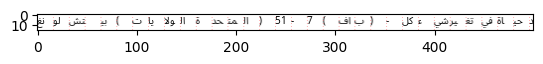

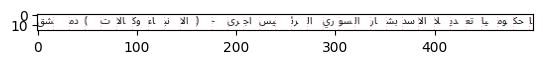

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

def tensor_to_numpy(pixel_values):
    if isinstance(pixel_values, torch.Tensor):
        if pixel_values.dim() == 3:  # [C, H, W]
            if pixel_values.shape[0] == 3:  # RGB
                return pixel_values.permute(1, 2, 0).cpu().numpy()
            else:  # Grayscale
                return pixel_values[0].cpu().numpy()
        else:
            return pixel_values.cpu().numpy()
    return np.array(pixel_values)

def crop_to_text_width(img_array, num_patches, patch_width=16):
    text_width = int(num_patches * patch_width)
    if img_array.shape[1] > text_width:
        if len(img_array.shape) == 2:
            return img_array[:, :text_width]
        else:
            return img_array[:, :text_width, :]
    return img_array

def add_patch_boundaries(img_array, num_patches, patch_width=16):
    # Create a copy to avoid modifying the original
    img_with_boundaries = img_array.copy()
    text_width = int(num_patches * patch_width)
    
    # Add dashed vertical lines at patch boundaries
    for patch_start in range(patch_width, text_width, patch_width):
        if patch_start < img_array.shape[1]:
            # Create dashed line pattern (every 3rd pixel) with alpha blending
            for y in range(0, img_array.shape[0], 3):
                if y < img_array.shape[0]:
                    if len(img_array.shape) == 2:  # Grayscale
                        # Alpha blend with existing pixel
                        original = img_with_boundaries[y, patch_start]
                        img_with_boundaries[y, patch_start] = 0.5 * 0.5 + original * 0.5
                    else:  # RGB
                        # Alpha blend with existing pixel
                        original = img_with_boundaries[y, patch_start, :]
                        line_color = np.array([1, 0.4, 0.4])
                        img_with_boundaries[y, patch_start, :] = line_color * 0.5 + original * 0.5

    return img_with_boundaries

def example_to_image(example):
    pixel_values = example['pixel_values']
    num_patches = example['attention_mask'].sum()
    
    img_array = tensor_to_numpy(pixel_values)
    img_array = crop_to_text_width(img_array, num_patches)
    img_array = add_patch_boundaries(img_array, num_patches)
    
    # Convert to PIL Image for saving
    if len(img_array.shape) == 2:  # Grayscale
        img = Image.fromarray((img_array * 255).astype(np.uint8), mode='L')
    else:  # RGB
        img = Image.fromarray((img_array[:,:500,:] * 255).astype(np.uint8))
    return img

plt.imshow(example_to_image(eval_dataset[1]))
plt.show()
plt.imshow(example_to_image(test_dataset[1]))
plt.show()

In [37]:
eval_dataset_7[5]["pixel_values"].shape

torch.Size([3, 16, 4096])

## Setup Training Arguments and Trainer

Configure the training arguments and initialize the trainer.

In [ ]:
# Define metrics computation function
def compute_metrics(p: EvalPrediction):
    """Compute UAS and LAS metrics for dependency parsing."""
    arc_labels, rel_labels = p.label_ids
    arc_preds, rel_preds = p.predictions

    correct_arcs = np.equal(arc_preds, arc_labels)
    correct_rels = np.equal(rel_preds, rel_labels)
    correct_arcs_and_rels = correct_arcs * correct_rels

    unlabeled_correct = correct_arcs.sum()
    labeled_correct = correct_arcs_and_rels.sum()
    total_words = correct_arcs.size

    unlabeled_attachment_score = unlabeled_correct / total_words
    labeled_attachment_score = labeled_correct / total_words

    return {
        "uas": unlabeled_attachment_score * 100,
        "las": labeled_attachment_score * 100,
    }

# Setup training arguments
training_args = PIXELTrainingArguments(
    output_dir=config.output_dir,
    run_name=config.run_name,
    do_train=config.do_train,
    do_eval=config.do_eval,
    do_predict=config.do_predict,
    per_device_train_batch_size=config.per_device_train_batch_size,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    learning_rate=config.learning_rate,
    warmup_steps=config.warmup_steps,
    max_steps=config.max_steps,
    logging_strategy="steps",
    logging_steps=config.logging_steps,
    evaluation_strategy="steps",
    eval_steps=config.eval_steps,
    save_strategy="steps",
    save_steps=config.save_steps,
    save_total_limit=config.save_total_limit,
    load_best_model_at_end=config.load_best_model_at_end,
    metric_for_best_model=config.metric_for_best_model,
    overwrite_output_dir=config.overwrite_output_dir,
    seed=config.seed,
    bf16=config.bf16,
    half_precision_backend="cuda_amp",
    dataloader_num_workers=config.dataloader_num_workers,
    report_to="none",  # Disable wandb for notebook
    log_predictions=config.log_predictions,
    label_names=["arc_labels", "rel_labels"],  # Specific to dependency parsing
    early_stopping=config.early_stopping,
    early_stopping_patience=config.early_stopping_patience,
)

print("Training arguments configured:")
print(f"Output directory: {training_args.output_dir}")
print(f"Max steps: {training_args.max_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Early stopping: {training_args.early_stopping}")

# Create output directory if it doesn't exist
os.makedirs(config.output_dir, exist_ok=True)

[INFO|training_args.py:1194] 2025-11-01 18:47:30,622 >> Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
[INFO|training_args.py:1537] 2025-11-01 18:47:30,726 >> PyTorch: setting up devices


Training arguments configured:
Output directory: ../debug/pixel-m4/udp/UD_Japanese-GSD/1e-5--0
Max steps: 15000
Learning rate: 1e-05
Batch size: 64
Early stopping: True


In [ ]:
# Initialize the trainer
trainer = PIXELTrainerForBiaffineParsing(
    model=model,
    args=training_args,
    train_dataset=train_dataset if config.do_train else None,
    eval_dataset=eval_dataset if config.do_eval else None,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
    tokenizer=processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=config.early_stopping_patience)]
    if config.early_stopping
    else None,
)

print("Trainer initialized successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

[INFO|trainer.py:564] 2025-11-01 18:47:31,170 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:621] 2025-11-01 18:47:31,171 >> Using cuda_amp half precision backend


Trainer initialized successfully!
Model parameters: 109,526,860
Trainable parameters: 109,526,860


## Start Training

Now let's start the finetuning process! This will train the model on the dependency parsing task.

In [ ]:
# Start training
if config.do_train:
    print("Starting training...")
    print(f"Training for {config.max_steps} steps")
    print(f"Evaluation every {config.eval_steps} steps")
    print(f"Saving model every {config.save_steps} steps")
    
    train_result = trainer.train()
    metrics = train_result.metrics
    
    # Add training dataset size to metrics
    metrics["train_samples"] = len(train_dataset)
    
    # Save the final model
    trainer.save_model()
    
    # Log and save training metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()
    
    print("Training completed!")
    print(f"Final training loss: {metrics.get('train_loss', 'N/A')}")
    print(f"Training runtime: {metrics.get('train_runtime', 'N/A'):.2f} seconds")
    print(f"Samples per second: {metrics.get('train_samples_per_second', 'N/A'):.2f}")
else:
    print("Training skipped (do_train=False)")

Starting training...
Training for 15000 steps
Evaluation every 500 steps
Saving model every 500 steps
11/01/2025 18:47:31 - INFO - pixel.trainer - ***** Running training *****
11/01/2025 18:47:31 - INFO - pixel.trainer -   Num examples = 7,050
11/01/2025 18:47:31 - INFO - pixel.trainer -   Num Epochs = 536
11/01/2025 18:47:31 - INFO - pixel.trainer -   Instantaneous batch size per device = 64
11/01/2025 18:47:31 - INFO - pixel.trainer -   Total train batch size (w. parallel, distributed & accumulation) = 256
11/01/2025 18:47:31 - INFO - pixel.trainer -   Gradient Accumulation steps = 1
11/01/2025 18:47:31 - INFO - pixel.trainer -   Total optimization steps = 15,000
11/01/2025 18:47:31 - INFO - pixel.trainer -   Number of trainable parameters = 109,526,860


/home/bens/miniconda3/envs/pixel-m4/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 2; 23.59 GiB total capacity; 136.50 MiB already allocated; 8.12 MiB free; 144.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Evaluation

Evaluate the trained model on the development and test sets.

In [ ]:
# Evaluation on development set
if config.do_eval and eval_dataset:
    print("*** Evaluating on development set ***")
    
    outputs = trainer.predict(test_dataset=eval_dataset, metric_key_prefix="eval")
    metrics = outputs.metrics
    
    # Add evaluation dataset size to metrics
    metrics["eval_samples"] = len(eval_dataset)
    
    # Log and save evaluation metrics
    trainer.log_metrics("eval", metrics)
    trainer.save_metrics("eval", metrics)
    
    print(f"Evaluation UAS: {metrics.get('eval_uas', 'N/A'):.2f}%")
    print(f"Evaluation LAS: {metrics.get('eval_las', 'N/A'):.2f}%")
    print(f"Evaluation loss: {metrics.get('eval_loss', 'N/A'):.4f}")
    
    # Save predictions if requested
    if config.log_predictions:
        # Note: In a real scenario, you'd implement the log_predictions function
        # from the original script. For simplicity, we're just noting this here.
        print("Predictions would be saved to eval_predictions.csv")
else:
    print("Evaluation skipped")

In [ ]:
# Testing on test set
if config.do_predict and test_dataset:
    print("*** Testing on test set ***")
    
    outputs = trainer.predict(test_dataset=test_dataset, metric_key_prefix="test")
    metrics = outputs.metrics
    
    # Add test dataset size to metrics
    metrics["test_samples"] = len(test_dataset)
    
    # Log and save test metrics
    trainer.log_metrics("test", metrics)
    trainer.save_metrics("test", metrics)
    
    print(f"Test UAS: {metrics.get('test_uas', 'N/A'):.2f}%")
    print(f"Test LAS: {metrics.get('test_las', 'N/A'):.2f}%")
    print(f"Test loss: {metrics.get('test_loss', 'N/A'):.4f}")
    
    # Save predictions if requested
    if config.log_predictions:
        # Note: In a real scenario, you'd implement the log_predictions function
        # from the original script. For simplicity, we're just noting this here.
        print("Predictions would be saved to test_predictions.csv")
else:
    print("Testing skipped")

## Summary

Training completed! Here's a summary of what we accomplished:

1. **Configuration**: Set up all training parameters in a notebook-friendly way
2. **Model Loading**: Loaded and configured the PIXEL-M4 model for dependency parsing
3. **Data Processing**: Set up the text renderer/tokenizer and loaded UD datasets
4. **Training**: Finetuned the model with early stopping and evaluation metrics
5. **Evaluation**: Evaluated the model on both development and test sets

The trained model is saved in the output directory and can be used for dependency parsing tasks.

### Key Results:
- **UAS (Unlabeled Attachment Score)**: Measures how well the model identifies syntactic heads
- **LAS (Labeled Attachment Score)**: Measures how well the model identifies both heads and dependency relations

### Next Steps:
- Analyze the saved predictions in the CSV files
- Experiment with different hyperparameters
- Try different Universal Dependencies treebanks
- Use the trained model for inference on new text